# Explore teeth dataset


In [1]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 135639, done.
remote: Counting objects: 100% (1859/1859), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 135639 (delta 1679), reused 1807 (delta 1670), pack-reused 133780
Receiving objects: 100% (135639/135639), 264.47 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (119176/119176), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [2]:
from __future__ import print_function, division
from google.colab import output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import time
import os
from os.path import exists
import copy
import transforms as T

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time
from time import sleep
from datetime import datetime
import random

plt.ion()   # interactive mode

In [3]:
# Access to uploaded files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Logger:
  def __init__(self, logger=None):
    self.logger = logger
  
  def log(self, msg):
    self._do(msg)
    if self.logger:
     self.logger.log(msg)
  
  def _do(self, msg):
    pass


class PrintLogger(Logger):
  def _do(self, msg):
    print(msg)

class TxtFileLogger(Logger):
  def __init__(self, path_to_file, logger=None):
    super().__init__(logger)
    self.path_to_file = path_to_file
    self.file = open(self.path_to_file, 'a')
  
  def _do(self, msg):
    self.file.write(msg + '\n')
    self.file.flush()
  
  def __del__(self):
    self.file.close()

In [5]:
dir_prefix = 'drive/My Drive/Colab Notebooks/Diplomski'

In [6]:
attrs_of_interest = ['bridge', 'endofilling', 'filling', 'crown']

def default_labeler(row):
  """ returns a list of labels which ranging from 1 to n, refering to a string label in array attrs_of_interest """
  label = []
  for i in range(len(attrs_of_interest)):
    if row[attrs_of_interest[i]] == 'yes': label.append(i + 1)
  return label

class XRayDataset(torch.utils.data.Dataset):
    def __init__(self, root, csv_file, subset=None, transforms=None, labeler=default_labeler):
        self.root = root
        self.transforms = transforms
        self.csv_file = csv_file
        self.subset = subset
        self.labeler = labeler
        self.df = pd.read_csv(csv_file, sep = ";")
        if self.subset: self.df = self.subset(self.df)
        self.object_data_by_img = dict()
        
        for index, row in self.df.iterrows():       # Returns integer for a label if [] is returned the row is skipped 
          label = self.labeler(row)
          for lbl in label:
            if not row['img_name'] in self.object_data_by_img: 
              self.object_data_by_img[row['img_name']] = list()
            
            self.object_data_by_img[row['img_name']].append((lbl, row['x1'], row['y1'], row['x2'], row['y2']))

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(self.object_data_by_img))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each object
        objs = self.object_data_by_img[self.imgs[idx]]
        num_objs = len(objs)
        labels = [x[0] for x in objs]
        boxes = [[x[1], x[2], x[3], x[4]] for x in objs] # Get x1, y1, x2, y2, bounding box coordinates of the tooth

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # convert everything into a torch.Tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
# Func for more transforms if the need arises
def get_transform():
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [8]:
def keep_only_subset(df, num_of_total_negatives=-1, num_of_positives=-1):
  df_some_yes = df[~((df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no'))]
  df_all_no = df[(df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no')]
  if num_of_total_negatives >= 0:
    df_all_no = df_all_no.sample(n=num_of_total_negatives, random_state=1)
  if num_of_positives >= 0:
    df_some_yes = df_some_yes.sample(n=num_of_positives, random_state=1)
  print(f'len(df_some_yes): {len(df_some_yes)}, len(df_all_no): {len(df_all_no)}')
  return pd.concat([df_some_yes,df_all_no]).copy()

In [9]:
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image_datasets = dict()
dataloaders = dict()
dataset_sizes = dict()
class_names = dict()

csv_filename = os.path.join(dir_prefix, 'multi_label_dataset', 'tooth_info.csv')
img_dir = os.path.join(dir_prefix, 'data_store')
dataset = XRayDataset(root=img_dir,
                      csv_file=csv_filename,
                      subset=lambda df: keep_only_subset(df, num_of_total_negatives=0),
                      transforms=get_transform())


first = dataset[0]
print(first[1])

len(df_some_yes): 8790, len(df_all_no): 0
{'boxes': tensor([[ 789.,  421.,  942.,  767.],
        [ 902.,  407., 1099.,  774.],
        [1486.,  404., 1609.,  811.],
        [2069.,  444., 2262.,  771.],
        [1539.,  801., 1629., 1137.],
        [1469.,  804., 1576., 1147.]]), 'labels': tensor([3, 3, 3, 3, 1, 4]), 'image_id': tensor([0]), 'area': tensor([52938., 72299., 50061., 63111., 30240., 36701.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0])}


In [10]:
font = ImageFont.truetype("LiberationMono-Bold.ttf", size=60)
font2 = ImageFont.truetype("LiberationMono-Bold.ttf", size=80)



iter=64
Examining best-mean-faulty-feeble-sedate-psychology_ede83e307338ee3ef79fe732da6566f1.jpg...


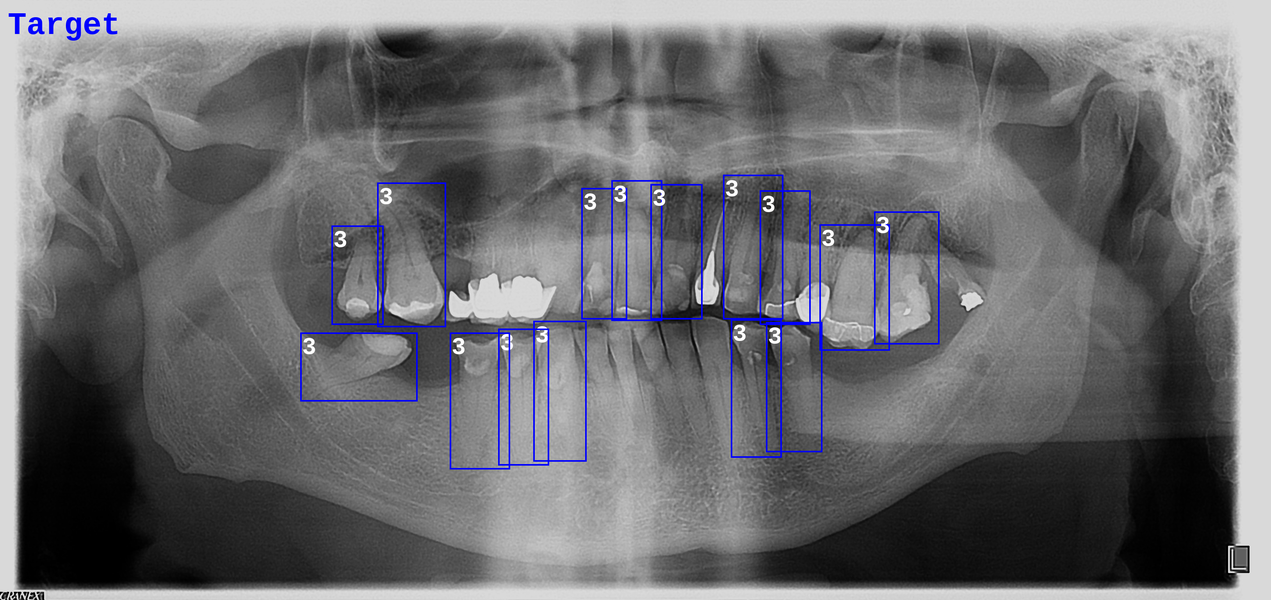



iter=9
Examining ablaze-lying-brown-dry-homely-slide_4080b7eaaeaec54aa2c95c23cc4e743b.jpg...


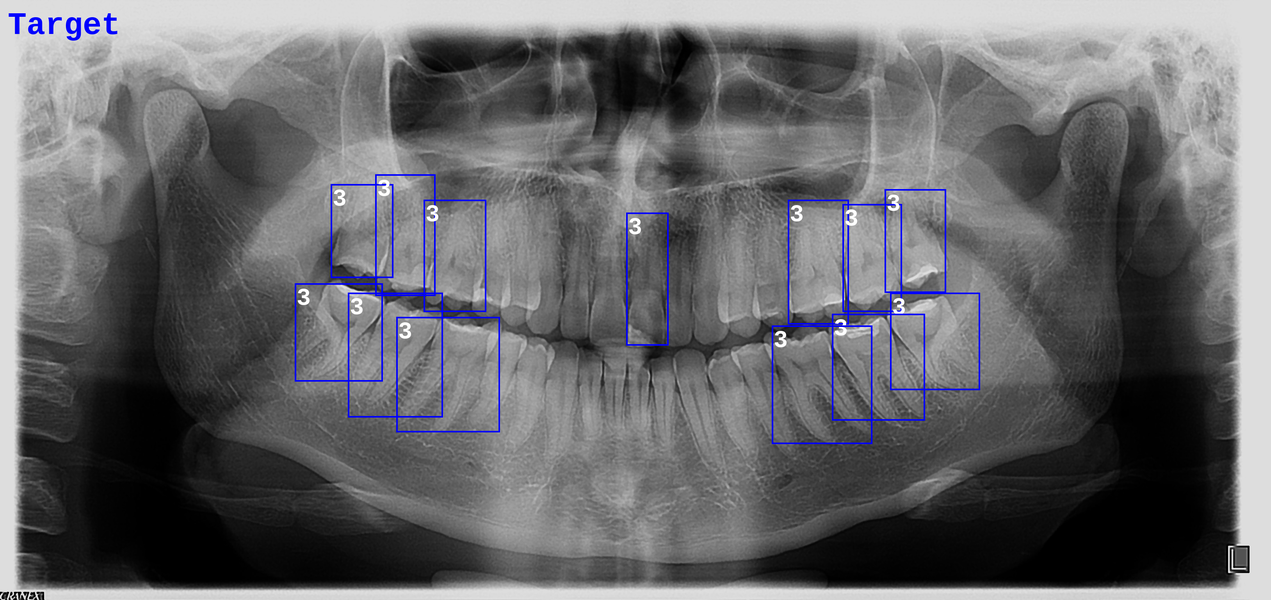



iter=13
Examining abortive-aboard-vulgar-quickest-better-presence_71a46cb1374ab245b3090a71aa3d8c61.jpg...


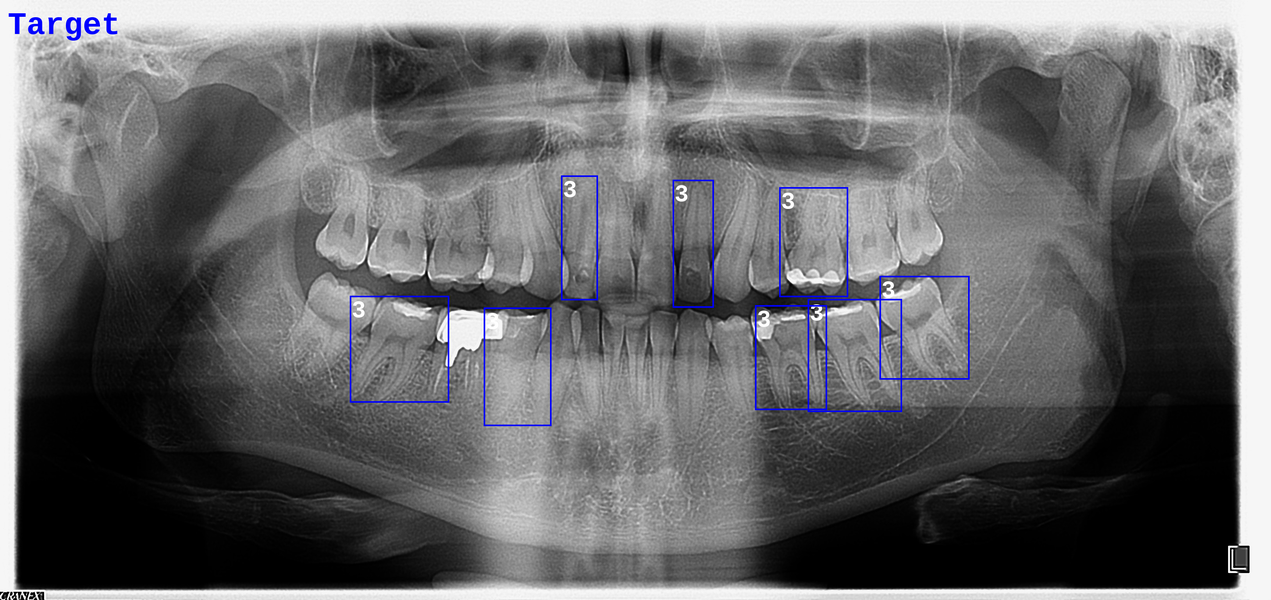

In [ ]:
interesting_imgs = ['best-mean-faulty-feeble-sedate-psychology_ede83e307338ee3ef79fe732da6566f1.jpg',
                    'ablaze-lying-brown-dry-homely-slide_4080b7eaaeaec54aa2c95c23cc4e743b.jpg', 
                    'abortive-aboard-vulgar-quickest-better-presence_71a46cb1374ab245b3090a71aa3d8c61.jpg',
                    'absorbing-little-old-misty-silly-active_9f677b7d08e846c4c70bb9eb27b289ed.jpg',
                    'acid-guttural-jaded-chubby-screeching-job_69f4dcb9704ca3bfa0326f51a6ee26ec.jpg',
                    'ad hoc-cautious-hungry-vigorous-level-hate_525861789c43ccdb2c0a245527bdfada.jpg',
                    'alluring-tricky-penitent-open-earthy-tonight_f6d4e8e85d58c1fc827a9a9d77583954.jpg',
                    'amazing-rabid-opposite-opposite-sedate-stress_d5fd06e8b807c3beffa054558cc209ab.jpg']

interesting_indexes = [dataset.imgs.index(x) for x in interesting_imgs]

log = PrintLogger()
for j in interesting_indexes:
  img, t = dataset[j]
  print()  
  #print("Target:")
  #print(t)

  img_name = dataset.imgs[int(t['image_id'])]
  log.log(f'\niter={j}\nExamining {img_name}...')
  img_target = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  imgdt = ImageDraw.Draw(img_target)  
  font = ImageFont.truetype("LiberationMono-Bold.ttf", size=60)
  for i, l in enumerate(t['labels']):
    if not int(l) == 3: continue
    imgdt.rectangle(t['boxes'][i].tolist(), outline ="blue", width=4)
    txt_coords = tuple(t['boxes'][i].tolist()[:2])
    final_coords = (txt_coords[0] + 5, txt_coords[1] + 5)
    imgdt.text(final_coords, str(int(l)), font=font, align ="left")
  imgdt.text((20,20), 'Target', font=font2, align ="left", fill='blue')
  img_target = img_target.resize((1271, 600), Image.ANTIALIAS)
  display(img_target)
  sleep(0.25)
  is_over = False
  is_over = not (input('1 -> continue, anything else -> exit:') == '1')
  if is_over: break
